In [1]:
import sys
sys.path.append('/home/enes/bim/')# you should have this package on the sys.path

from utils import InferEta, Neutrality_Tests, Colless, intersect_with_weights
from Bimbalance import bSFS, bTree, PConst,Pnkb

import tskit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from tqdm.notebook import tqdm

import sys, os
sys.path = ['/home/enes/.conda/envs/gene/lib/python3.8/site-packages'] + sys.path
import pyslim
import numpy as np
import msprime as msp
from IPython.display import SVG, display

plt.style.use('default')

import jax.numpy as jnp
from jax import lax
import jax
from jax.scipy.special import gammaln as LG
jax.config.update("jax_enable_x64", True)

from gmpy2 import mpq
import gmpy2
gmpy2.get_context().precision = 1000

from functools import partial, lru_cache
from dataclasses import dataclass
import scipy
import tskit
import re
import numpy as np

from utils import tree_to_splits

def H(n):
    i = np.arange(1,n+1)
    return np.sum(1/i)

@lru_cache(None)
def _nc2(N):
    return N * (N - 1) // 2

@lru_cache(None)
def _A(N):
    '''
    returns A_jk calculated as eq6 @ Polanski

    Parameters
    ----------
    N : int
        sample size.

    Returns
    -------
    A : ndarray

    '''
    A = np.zeros([N - 1, N - 1], dtype=object)
    for k in range(2, N + 1):
        for j in range(k, N + 1):
            A[k - 2, j - 2] = np.prod([mpq(_nc2(ell), _nc2(ell) - _nc2(j)) for ell in range(k, N + 1) if ell != j])
    A[N - 2, N - 2] = 1
    return A

def get_BETmm(eta, N):
    j = np.arange(2, N + 1)
    k = np.arange(2, N + 1)
    A = _A(N)
    B = (A * (j * (j - 1))[None, :] / (k - 1)[:, None])
    ETmm = [eta.exp_integral(j * (j - 1) // 2) for j in range(2, N + 1)]
    BETmm = B @ ETmm        
    return BETmm.astype('float')

def get_pmf(n, beta):
    beta = 2*(jnp.exp(beta)-1)
    k = jnp.arange(n+1)
    norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+
                     LG(-0.5-beta)+LG(1+beta)-LG(-1-2*beta-n)-LG(1+n), 0)

    if np.isnan(norm):
        norm = jnp.where(beta>1, np.log(2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+
                         LG(-0.5-beta)+LG(1+beta)-LG(-1-2*beta-n)-LG(1+n), 0)

    fx = LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1)
    fx = jnp.exp(fx - norm)
    fx = fx[1:-1]
    fx = fx/fx.sum()
    return fx

def Pnkb(N, beta):
       
    P = np.zeros((N, N))

    for n in range(1, N+1):
        P[n-1, :(n-1)] = 2*get_pmf(n, beta)
    
    P = P - jnp.identity(N)
    
    State = jnp.zeros(N)
    State = jax.ops.index_update(State, jax.ops.index[N-1], 1)
    lins = jnp.arange(N)
    State = State.reshape(1, N)
       
    mean_ling = jnp.concatenate([jnp.zeros(N - 1), jnp.ones(1)])
    def loop_body(mean_ling_im1, i):
        State = i * mean_ling_im1
        probs = lins * State # weight the probs with size (Durett forward split)
        probs /= jnp.sum(probs)
        State += jnp.matmul(probs, P)      
        State = jax.ops.index_update(State, jax.ops.index[-i], 0)
        return (State / (i + 1),) * 2

    _, mean_ling = lax.scan(loop_body, mean_ling, jnp.arange(1, N))
    
    return mean_ling[:,:-1]

In [2]:
def get_P(n, beta):
    # Probability matrix for size based beta-binom (aldous)
    P = np.zeros((n-1, n-1))
    for i in range(2, n+1):
        P[i-2, :(i-1)] = get_pmf(i, beta)

    return P

def sim_vard(P):
    # topology simulator
    n = P.shape[0]+1       

    splits = np.zeros((n-1, 2))
        
    l = np.arange(n)
    S = np.zeros(n)
    S[n-1] = 1
    pos_splits = np.arange(1, n)
    
    vardks = []
    avgvar = 0
    for i in l[:-1]:
        probs = S*l
        selected_lin = np.random.choice(l, 1, p = probs/probs.sum())[0]

        split = np.random.choice(pos_splits[:(selected_lin)], 1, p = P[selected_lin-1,:(selected_lin)])[0]
        k1, k2 = split, selected_lin+1-split
        S[k1-1] += 1
        S[k2-1] += 1
        S[selected_lin] = S[selected_lin] - 1
                
        var_dk = np.var(np.repeat(l[1:], S[:-1].astype('int')))
        avgvar += var_dk/(i+1)
        vardks.append(var_dk)
        splits[i, :] = [k1,k2]
     
    #return vardks
    return avgvar/H(n-1)
    #return ret[1:,:-1].astype('int')
    
def sim_bl(N):
    # branch length simulator
    ts = msp.simulate(N)
    tree = ts.first()
    bls = np.array([tree.time(i) for i in tree.nodes(order = 'timedesc') if tree.is_internal(i)]+[0])
    bls = bls[:-1]-bls[1:]
    return bls

def get_ET(vard, t, a, b, g):
    # get eq17 in Feretti
    n = len(t)+1
    k = np.arange(2, n+1)
    l = sum(t*k)
    
    ftl = 1 # ?
    return ftl*( a*vard + ((t/l)*(a*(n**2)/k+b*n+g*k)).sum())

In [6]:
N = 100
k = np.arange(2, N+1)
an = H(N-1)

betas = np.linspace(-4, 4, 21)
nit = 2500

### Tajima's D

In [7]:
a = -2/(N*(N-1))
b = 2/(N-1)
g = -1/an

Ds = {}
for beta in tqdm(betas):
    P = get_P(N, beta)

    Ds[beta] = [get_ET(sim_vard(P), sim_bl(N), a, b, g) for _ in range(nit)]    

<ipython-input-1-9f16b170fad1>:85: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [11]:
dfD = pd.DataFrame({'beta': np.round(np.repeat(betas, nit),2), 'D':np.array(list(Ds.values())).flatten()})

In [10]:
vardkm2 = (k-1)*(N/k-1)**2
vardm2 = sum(vardkm2/(k-1))/an

vardinf = N/4

Dlims = {}
Dlims['-inf'] = [get_ET(vardm2, sim_bl(N), a, b, g) for _ in range(10000)]
Dlims['inf'] = [get_ET(vardinf, sim_bl(N), a, b, g) for _ in range(10000)]

### Fay H

In [12]:
a = -4/(N*(N-1))
b = 2/(N-1)
g = 0

Hs = {}
for beta in tqdm(betas):
    P = get_P(N, beta)

    Hs[beta] = [get_ET(sim_vard(P), sim_bl(N), a, b, g) for _ in range(nit)]    

<ipython-input-1-9f16b170fad1>:85: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [14]:
dfH = pd.DataFrame({'beta': np.round(np.repeat(betas, nit),2), 'D':np.array(list(Hs.values())).flatten()})

In [15]:
Hlims = {}
Hlims['-inf'] = [get_ET(vardm2, sim_bl(N), a, b, g) for _ in range(10000)]
Hlims['inf'] = [get_ET(vardinf, sim_bl(N), a, b, g) for _ in range(10000)]

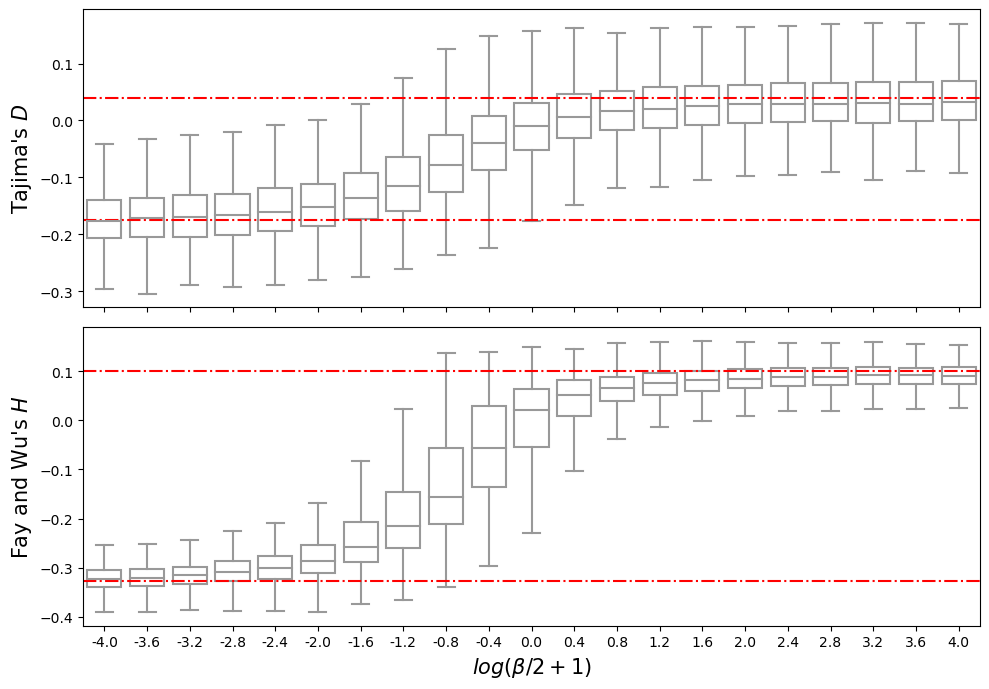

In [35]:
fig, ax = plt.subplots(2,1,figsize = (10,7), sharex = True)

sns.boxplot(data=dfD, x='beta', y='D', 
            showfliers=False, color = 'white', ax=ax[0])

ax[0].axhline(np.mean(Dlims['-inf']), color = 'red', linestyle = '-.')
ax[0].axhline(np.mean(Dlims['inf']), color = 'red', linestyle = '-.')
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Tajima's $D$",size = 15)

sns.boxplot(data=dfH, x='beta', y='D', 
            showfliers=False, color = 'white', ax=ax[1])

ax[1].axhline(np.mean(Hlims['-inf']), color = 'red', linestyle = '-.')
ax[1].axhline(np.mean(Hlims['inf']), color = 'red', linestyle = '-.')
ax[1].set_ylabel(r"Fay and Wu's $H$",size = 15)
ax[1].set_xlabel(r'$log(\beta/2+1)$', size = 15)
plt.tight_layout()
plt.savefig('plots/sampledNTs.jpg', dpi = 300)